# Deep-TICA: Neural network basis functions for TICA

### Import

In [1]:
# IMPORT PACKAGES
import torch
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcvs.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Unbiased data (high temperature MD)

### Load

In [9]:
from mlcvs.utils.io import load_dataframe
from mlcvs.utils.timelagged import create_timelagged_dataset
from mlcvs.data import DictionaryDataModule

filenames = [ "data/muller-brown/unbiased/high-temp/COLVAR" ]

# load file
df = load_dataframe(filenames)

# get descriptors
X = df.filter(regex='p.x|p.y').values

# build time-lagged dataset (composed by pairs of configs at time t, t+lag)
dataset = create_timelagged_dataset(X,lag_time=1)

# create datamodule
datamodule = DictionaryDataModule(dataset,lengths=[0.8,0.2])#,random_splits=False,shuffle=False)

/home/lbonati@iit.local/work/code/mlcvs/mlcvs/utils/timelagged.py:129: UserWarning: Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.
  warnings.warn('Monitoring the progress for the search of time-lagged configurations with a progress_bar requires `tqdm`.')


### Define model

In [12]:
from mlcvs.cvs import DeepTICA_CV

n_components = 2
nn_layers = [2,15,15,n_components]
nn_args = {'activation': 'tanh'}
loss_args = {'mode':'sum'}
options= {'nn': nn_args, 'loss':loss_args}

model = DeepTICA_CV (nn_layers, options=options )
model

DeepTICA_CV(
  (normIn): Normalization(in_features=2, out_features=2, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=15, bias=True)
      (1): Tanh()
      (2): Linear(in_features=15, out_features=15, bias=True)
      (3): Tanh()
      (4): Linear(in_features=15, out_features=2, bias=True)
    )
  )
  (tica): TICA(in_features=2, out_features=2)
)

### Define Trainer & Fit

In [13]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from mlcvs.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-5, patience=20)

# define trainer
trainer = pl.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name   | Type          | Params | In sizes | Out sizes
----------------------------------------------------------------
0 | normIn | Normalization | 0      | [2]      | [2]      
1 | nn     | FeedForward   | 317    | [2]      | [2]      
2 | tica   | TICA          | 0      | [2]      | [2]      
--

Epoch 999: 100%|██████████| 2/2 [00:00<00:00, 126.45it/s, loss=-1.37]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 2/2 [00:00<00:00, 120.63it/s, loss=-1.37]


### Plot metrics

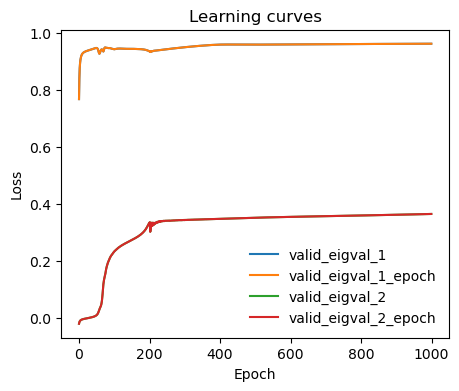

In [14]:
ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

### Normalize output

In [15]:
from mlcvs.core.transform import Normalization
from mlcvs.core.transform.utils import Statistics

X = dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset  
    s = model(torch.Tensor(X))

norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) ) 
model.postprocessing = norm
#print(Statistics(s))

### Plot CVs isolines

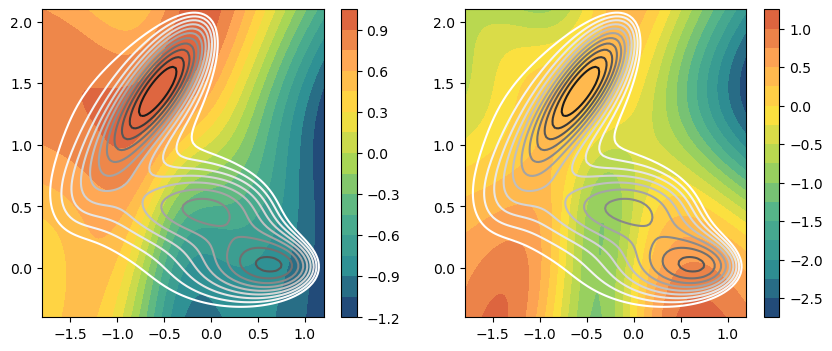

In [16]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=15, ax=ax)
    #plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)

### Plot FES

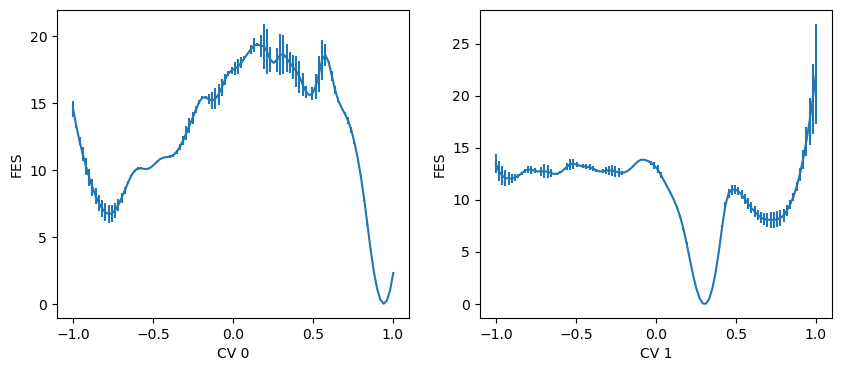

In [17]:
from mlcvs.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

X = dataset[:]['data']
model.eval()
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i,ax in enumerate(axs):
    fes,grid,bounds,std = compute_fes(s[:,i], kbt=2.5, plot=True, scale_by='range', bandwidth=0.02, blocks=2, plot_max_fes=30, ax=ax )
    ax.set_xlabel(f'CV {i}')

## Biased data (OPES, CV = p.y)

### Load data

In [4]:
from mlcvs.utils.io import load_dataframe
from mlcvs.utils.timelagged import create_timelagged_dataset
from mlcvs.data import DictionaryDataModule

filenames = [ "data/muller-brown/biased/opes-y/COLVAR" ]

# load file
df = load_dataframe(filenames,start=1000,stop=5000,stride=1)

# get descriptors
X = df.filter(regex='p.x|p.y').values
t = df['time'].values

# get logweights for time rescaling
beta = 1
bias = df['opes.bias'].values
bias -= np.max(bias)
logweights = beta*bias
df['logweights'] = logweights

df

,time,p.x,p.y,p.z,ene,pot.bias,pot.ene_bias,opes.bias,opes.rct,opes.zed,opes.neff,opes.nker,lwall.bias,lwall.force2,uwall.bias,uwall.force2,walker,logweights
0,1000.0,-0.702983,1.270586,0.0,1.497454,1.497454,1.497454,-1.525539,0.683371,0.129893,454.409464,30.0,0.0,0.0,0.0,0.0,0,-1.525539
1,1001.0,-0.854688,1.075298,0.0,5.773617,5.773617,5.773617,-5.236936,0.682388,0.129891,454.431737,30.0,0.0,0.0,0.0,0.0,0,-5.236936
2,1002.0,-1.094547,0.633480,0.0,15.123240,15.123240,15.123240,-10.012412,0.681382,0.125702,454.431926,31.0,0.0,0.0,0.0,0.0,0,-10.012412
3,1003.0,-0.627915,1.431668,0.0,0.626873,0.626873,0.626873,-0.287195,0.683850,0.125667,455.096616,31.0,0.0,0.0,0.0,0.0,0,-0.287195
4,1004.0,-0.384823,1.537301,0.0,2.076623,2.076623,2.076623,-0.704820,0.685127,0.125602,456.095103,31.0,0.0,0.0,0.0,0.0,0,-0.704820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4995.0,-0.535296,1.438769,0.0,0.108544,0.108544,0.108544,-0.171635,0.546526,0.118832,1726.055577,45.0,0.0,0.0,0.0,0.0,0,-0.171635
3996,4996.0,-0.667636,1.434562,0.0,1.719826,1.719826,1.719826,-0.169992,0.547217,0.118827,1726.764048,45.0,0.0,0.0,0.0,0.0,0,-0.169992
3997,4997.0,-0.685647,1.326269,0.0,0.872405,0.872405,0.872405,-0.862706,0.547463,0.118819,1727.711219,45.0,0.0,0.0,0.0,0.0,0,-0.862706
3998,4998.0,-0.891465,1.047566,0.0,6.479710,6.479710,6.479710,-5.753119,0.547266,0.118819,1727.722767,45.0,0.0,0.0,0.0,0.0,0,-5.753119


<AxesSubplot:xlabel='time', ylabel='p.y'>

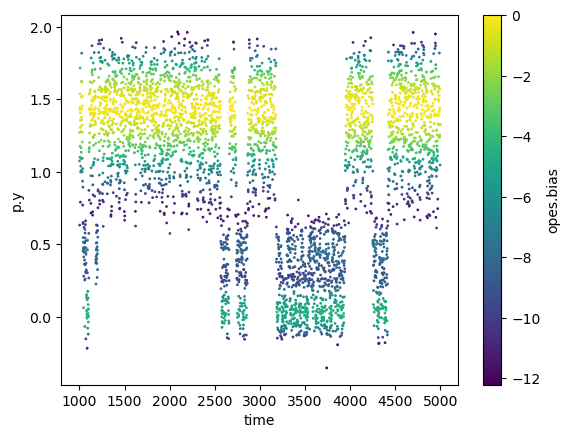

In [5]:
df.plot.scatter('time','p.y',c='opes.bias',s=1)

<AxesSubplot:xlabel='p.x', ylabel='p.y'>

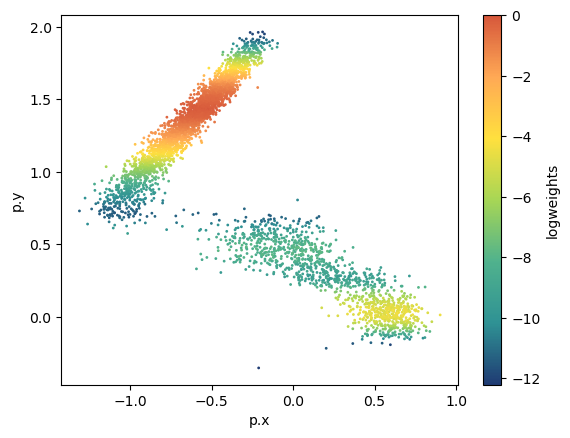

In [6]:
df.plot.scatter('p.x','p.y',c='logweights',s=1,cmap='fessa')

### Create time-lagged dataset

In [ ]:
lag_time = 100

# build time-lagged dataset (composed by pairs of configs at time t, t+lag)
dataset = create_timelagged_dataset(X,t,lag_time=lag_time, logweights=logweights, progress_bar=True)

# create datamodule
datamodule = DictionaryDataModule(dataset,lengths=[0.8,0.2],random_splits=False,shuffle=False)

100%|██████████| 3898/3898 [00:00<00:00, 29768.61it/s]


### Define model

In [13]:
from mlcvs.cvs import DeepTICA_CV

n_components = 1
nn_layers = [2,10,10,n_components]
nn_args = {'activation': 'tanh'}
loss_args = {'mode':'sum'}
options= {'nn': nn_args, 'loss':loss_args}

model = DeepTICA_CV (nn_layers, options=options )
model

DeepTICA_CV(
  (normIn): Normalization(in_features=2, out_features=2, mode=mean_std)
  (nn): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Tanh()
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (tica): TICA(in_features=1, out_features=1)
)

### Define Trainer & Fit

In [14]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from mlcvs.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", min_delta=1e-4, patience=20)

# define trainer
trainer = pl.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=500, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | In sizes | Out sizes
----------------------------------------------------------------
0 | normIn | Normalization | 0      | [2]      | [2]      
1 | nn     | FeedForward   | 151    | [2]      | [1]      
2 | tica   | TICA          | 0      | [1]      | [1]      
----------------------------------------------------------------
151       Trainable params
0         Non-trainable params
151       Total params
0.001     Total estimated model params size (MB)


Epoch 82: 100%|██████████| 2/2 [00:00<00:00, 148.87it/s, loss=-0.46]        


### Plot metrics

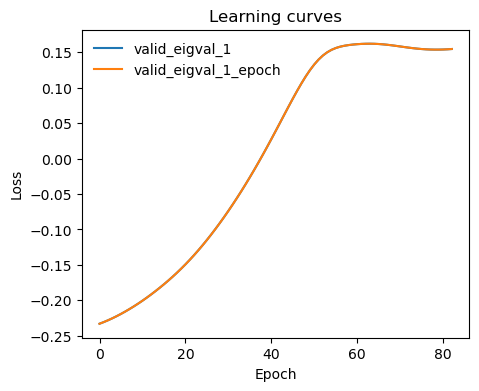

In [15]:
ax = plot_metrics(metrics.metrics, 
                  keys=[x for x in  metrics.metrics.keys() if 'valid_eigval' in x],#['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

### Normalize output

In [16]:
from mlcvs.core.transform import Normalization
from mlcvs.core.transform.utils import Statistics

X = dataset[:]['data']
with torch.no_grad():
    model.postprocessing = None # reset  
    s = model(torch.Tensor(X))

norm =  Normalization(n_components, mode='min_max', stats = Statistics(s) ) 
model.postprocessing = norm
#print(Statistics(s))

### Plot CVs isolines

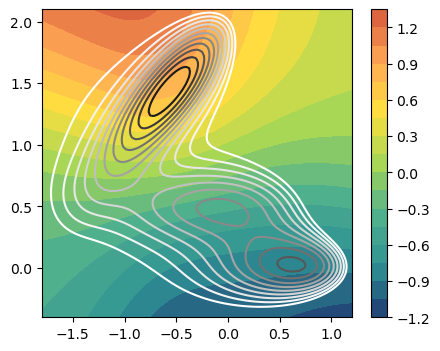

In [17]:
fig,axs = plt.subplots( 1, n_components, figsize=(5*n_components,4) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=15, ax=ax)
    #plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)

### Plot FES

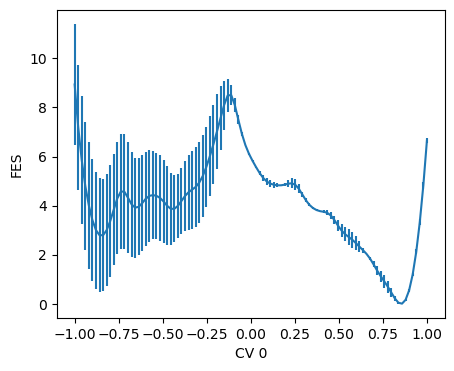

In [18]:
from mlcvs.utils.fes import compute_fes

fig,axs = plt.subplots(1,n_components,figsize=(5*n_components,4))
if n_components == 1:
    axs = [axs]

X = dataset[:]['data']
model.eval()
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i,ax in enumerate(axs):
    fes,grid,bounds,std = compute_fes(s[:,i], kbt=2.5, plot=True, scale_by='range', bandwidth=0.02, blocks=2, plot_max_fes=30, ax=ax )
    ax.set_xlabel(f'CV {i}')